# 从数据爬取到简单词云的完整流程

来自[用python爬取微博数据并生成词云](https://www.cnblogs.com/yangshunde/p/7742868.html)

## 准备工作

以下代码，哪里报错，安装什么包。

## 1.分析网址

打开微博移动端网址 https://m.weibo.cn/searchs ，找到待分析用户的微博ID

<img src="m_weibo_search.jpg", width=620, heigth=440>

<img src="njtech.jpg", width=320, heigth=240>

+ 进入微博主页，chrome“开发者工具”，分析浏览器发送请求的过程
+ 打开开发者工具后，需要刷新左侧网页，收集数据
+ 打开 Chrome 浏览器的调试功能，选择 Network 菜单，观察到获取微博数据的的接口是 https://m.weibo.cn/api/container/getIndex ，后面附带了一连串的参数，这里面有些参数是根据用户变化的，有些是固定的，先提取出来。

<img src="get_request.jpg", width=820, heigth=540>

+ cardlistInfo: {containerid: "1076031880207035", v_p: 42, show_style: 1, total: 11173, since_id: 4301251451406395}
+ containerid: "1076031880207035"
+ show_style: 1
+ since_id: 4301251451406395
+ total: 11173
+ v_p: 42

+ 再来分析接口的返回结果，返回数据是一个JSON字典结构，total 是微博总条数，每一条具体的微博内容封装在 cards 数组中，具体内容字段是里面的 text 字段。很多干扰信息已隐去。
+ 可以把Preview-cards-0、1、2、...10展开对照左侧数据，就能看到具体的数据

## 2.构建请求头和查询参数

分析完网页后，我们开始用 requests 模拟浏览器构造爬虫获取数据，因为这里获取用户的数据无需登录微博，所以我们不需要构造 cookie信息，只需要基本的请求头即可，具体需要哪些头信息也可以从浏览器中获取，首先构造必须要的请求参数，包括请求头和查询参数。

<img src="id_information.jpg", width=520, heigth=440>

+ uid: 1880207035
+ luicode: 10000011
+ lfid: 100103type=1&q=南京工业大学
+ type: uid
+ value: 1880207035
+ containerid: 1076031880207035

## 3. 构造简单爬虫

通过返回的数据能查询到总微博条数 total，爬取数据直接利用 requests 提供的方法把 json 数据转换成 Python 字典对象，从中提取出所有的 text 字段的值并放到 blogs 列表中，提取文本之前进行简单过滤，去掉无用信息。顺便把数据写入文件，方便下次转换时不再重复爬取

In [1]:
# -*- coding:utf-8 -*-
import codecs # python编码模块
import re # python正则表达式模块

In [2]:
import jieba.analyse #分词是必须的，分词分析
import matplotlib.pyplot as plt #想画个词云，matplotlib是必须的
import requests #爬虫请求包
from scipy.misc import imread #scipy数据分析包
from wordcloud import WordCloud # 词云

In [3]:
__author__ = 'liuzhijun' #版权申明

In [4]:
# 带爬取页面的头信息
headers = {
    "Host": "m.weibo.cn",
    "Referer": "https://m.weibo.cn/u/1768409523?uid=1768409523&t=0&luicode=10000011&lfid=100103type%3D1%26q%3D%E5%8D%97%E4%BA%AC%E5%A4%A7%E5%AD%A6",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36",
}

+ 定义一个函数clean_html，这个函数是把text中我们想分析的对象整体删除
+ [re.compile](https://www.cnblogs.com/nomorewzx/p/4203829.html)参考这个

In [5]:
# 这个函数是删除文本中的杂乱信息，只保留文本 ##采用正则表达式
def clean_html(raw_html):
    pattern = re.compile(r'<.*?>|转发微博|//:|Repost|，|？|。|、|分享图片|回复@.*?:|//@.*')
    text = re.sub(pattern, '', raw_html)
    return text

In [6]:
#交待爬虫函数fetch_data需要的参数
url = "https://m.weibo.cn/api/container/getIndex"
# uid和containerid在运行主函数中赋值
params = {"uid": "{uid}",
          "luicode": "10000011",
          #"featurecode": "20000320",
          "type": "uid",
          "value": "1768409523",
          "containerid": "{containerid}",
          "page": "{page}"}

In [7]:
def fetch_data(uid=None, container_id=None):
    """
    抓取数据，并保存到txt文件中
    :return:
    """
    page = 0
    total = 60 ## 这个参数很重要，不然大V的微博会耗时很久试一试20条
    blogs = []
    for i in range(0, total // 10): ## //是整除的意思 # 就是爬取该号十分之一（页）的内容
        params['uid'] = uid
        params['page'] = str(page)
        params['containerid'] = container_id
        # requests包是爬虫的核心，它的三个参数，已经定义好
        res = requests.get(url, params=params, headers=headers)
        cards = res.json().get("data").get("cards")

        for card in cards:
            # 每条微博的正文内容
            # 打开“开发者工具”看一看，Preview
            if card.get("card_type") == 9:
                text = card.get("mblog").get("text")
                text = clean_html(text)
                blogs.append(text)
        page += 1
        print("抓取第{page}页，目前总共抓取了 {count} 条微博".format(page=page, count=len(blogs)))
        # weibo.txt是事先创建的
        with codecs.open('weibo1.txt', 'w', encoding='utf-8') as f:
            f.write("\n".join(blogs))

+ 创建词云函数

In [8]:
def generate_image():
    data = []
    # stopwords是网上下载的，一个融合的停用词表
    jieba.analyse.set_stop_words("./stopwords.txt")
    
    # 对爬取的txt文本进行处理
    with codecs.open("weibo1.txt", 'r', encoding="utf-8") as f:
        for text in f.readlines():
            data.extend(jieba.analyse.extract_tags(text, topK=20)) #其中text为待提取的文本，topK为返回几个TF/IDF权重最大的关键词，默认值为20。
        data = " ".join(data)
        # 词云背景图
        #mask_img = imread('./njtech_logo_qiang.jpg', flatten=True)
        # 多试几个背景图片，出图效果和背景图的大小、色系、像素相关
        mask_img = imread('./njtech_logo1.jpg', flatten=True)
        wordcloud = WordCloud(
            font_path='msyh.ttc', ##微软雅黑字体
            background_color='white',
            mask=mask_img
        ).generate(data)
        
       #  plt.title("Njtech Weibo WordCloud")
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.savefig('./njtech_weibo1.jpg', dpi=1600)

抓取第1页，目前总共抓取了 9 条微博
抓取第2页，目前总共抓取了 18 条微博
抓取第3页，目前总共抓取了 27 条微博
抓取第4页，目前总共抓取了 37 条微博
抓取第5页，目前总共抓取了 46 条微博


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\dell\AppData\Local\Temp\jieba.cache


抓取第6页，目前总共抓取了 55 条微博


Loading model cost 0.916 seconds.
Prefix dict has been built successfully.
C:\Users\dell\Anaconda33\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\dell\Anaconda33\lib\site-packages\wordcloud\wordcloud.py:735: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


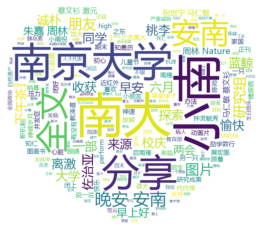

In [9]:
# 主函数（执行）
if __name__ == '__main__':
    fetch_data("768409523", "1076031768409523") ## 给爬虫函数输入两个重要参数
    generate_image()